In [1]:
import os
import json
import operator
import google.generativeai as genai
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, AIMessage, ChatMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, END
from pydantic.v1 import BaseModel
from tavily import TavilyClient
from typing import TypedDict, Annotated, List

In [2]:
memory = MemorySaver()

class AgentState(TypedDict):
    task: str
    plan: str
    draft: str
    critique: str
    content: List[str]
    revision_number: int
    max_revisions: int

class Queries(BaseModel):
    """Variants of query to search for"""
    queries: List[str]

In [3]:
model = ChatGoogleGenerativeAI(model="gemini-1.5-pro", temperature=0)

tavily = TavilyClient(api_key="")

In [4]:
PLAN_PROMPT = """You are an expert writer tasked with writing a high level outline of an essay. \
Write such an outline for the user provided topic. Give an outline of the essay along with any relevant notes \
or instructions for the sections."""

WRITER_PROMPT = """You are an essay assistant tasked with writing excellent 5-paragraph essays.\
Generate the best essay possible for the user's request and the initial outline. \
If the user provides critique, respond with a revised version of your previous attempts. \
Utilize all the information below as needed:

------

{content}"""

REFLECTION_PROMPT = """You are a teacher grading an essay submission. \
Generate critique and recommendations for the user's submission. \
Provide detailed recommendations, including requests for length, depth, style, etc."""

RESEARCH_PLAN_PROMPT = """You are a researcher charged with providing information that can \
be used when writing the following essay. Generate a list of search queries that will gather \
any relevant information. Only generate 3 queries max."""


RESEARCH_CRITIQUE_PROMPT = """You are a researcher charged with providing information that can \
be used when making any requested revisions (as outlined below). \
Generate a list of search queries that will gather any relevant information. Only generate 3 queries max."""

def plan_node(state: AgentState):
    messages = [
        SystemMessage(content=PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ]
    response = model.invoke(messages)
    return {"plan": response.content}

def research_plan_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_PLAN_PROMPT),
        HumanMessage(content=state['task'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

def generation_node(state: AgentState):
    content = "\n\n".join(state['content'] or [])
    user_message = HumanMessage(
        content=f"{state['task']}\n\nHere is my plan:\n\n{state['plan']}")
    messages = [
        SystemMessage(
            content=WRITER_PROMPT.format(content=content)
        ),
        user_message
        ]
    response = model.invoke(messages)
    return {
        "draft": response.content,
        "revision_number": state.get("revision_number", 1) + 1
    }

def reflection_node(state: AgentState):
    messages = [
        SystemMessage(content=REFLECTION_PROMPT),
        HumanMessage(content=state['draft'])
    ]
    response = model.invoke(messages)
    return {"critique": response.content}

def research_critique_node(state: AgentState):
    queries = model.with_structured_output(Queries).invoke([
        SystemMessage(content=RESEARCH_CRITIQUE_PROMPT),
        HumanMessage(content=state['critique'])
    ])
    content = state['content'] or []
    for q in queries.queries:
        response = tavily.search(query=q, max_results=2)
        for r in response['results']:
            content.append(r['content'])
    return {"content": content}

def should_continue(state):
    if state["revision_number"] > state["max_revisions"]:
        return END
    return "reflect"

In [5]:
builder = StateGraph(AgentState)

builder.add_node("planner", plan_node)
builder.add_node("generate", generation_node)
builder.add_node("reflect", reflection_node)
builder.add_node("research_plan", research_plan_node)
builder.add_node("research_critique", research_critique_node)

builder.set_entry_point("planner")

builder.add_conditional_edges(
    "generate",
    should_continue,
    {END: END, "reflect": "reflect"}
)

builder.add_edge("planner", "research_plan")
builder.add_edge("research_plan", "generate")

builder.add_edge("reflect", "research_critique")
builder.add_edge("research_critique", "generate")

graph = builder.compile(checkpointer=memory)

In [6]:
thread = {"configurable": {"thread_id": "1"}}
for s in graph.stream({
    'task': "What is the difference between LangChain and LangSmith?",
    "max_revisions": 2,
    "revision_number": 1,
    "content": [],
}, thread):
    print(s)

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


{'planner': {'plan': "## LangChain vs. LangSmith: A Comparative Exploration\n\n**I. Introduction**\n\n* Briefly introduce Large Language Models (LLMs) and their growing application in various fields.\n* Introduce LangChain and LangSmith as two tools within the LLM ecosystem.\n* State the essay's purpose: to provide a clear comparison of LangChain and LangSmith, highlighting their distinct functionalities, strengths, and weaknesses.\n\n**II. Understanding LangChain**\n\n* **Definition:** Explain LangChain as a framework for developing applications powered by LLMs.\n* **Key Features:**\n    * **Chain Creation:** Detail how LangChain allows chaining together different components like LLMs, prompts, and other tools.\n    * **Data Integration:** Discuss its ability to connect with various data sources.\n    * **Agent System:** Explain how LangChain enables the creation of agents that can interact with their environment.\n* **Use Cases:** Provide examples of applications built using LangChai

Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring
Key 'title' is not supported in schema, ignoring


{'reflect': {'critique': "## Essay Critique: LangChain vs. LangSmith\n\n**Overall Impression:**\n\nThis is a solid start to a comparative essay on LangChain and LangSmith. You clearly understand the basic functionalities of each tool and their importance in the LLM landscape. However, the essay feels more like a descriptive overview than a critical analysis. \n\n**Strengths:**\n\n* **Clear Structure:** The essay follows a logical structure, making it easy to follow.\n* **Concise Definitions:** You effectively explain the core purpose of both LangChain and LangSmith.\n* **Helpful Comparison Table:** The table provides a quick and clear visual comparison of key features.\n\n**Areas for Improvement:**\n\n* **Depth of Analysis:** The essay lacks in-depth analysis and critical comparison.  You primarily list features without delving into their nuances, limitations, or how they truly differ between the platforms.\n* **Real-World Examples:**  Illustrate your points with concrete examples. How

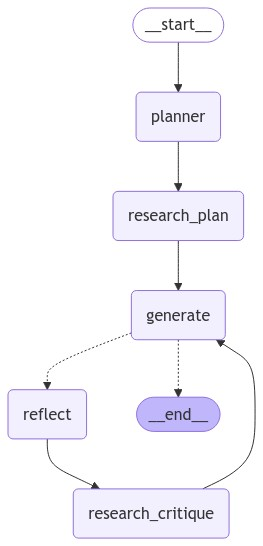

In [9]:
from IPython.display import Image

Image(graph.get_graph().draw_mermaid_png())

## Essay Writer Interface

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from helper import ewriter, writer_gui